In [1]:
import torch
import torch.optim as optim
import os
from resolve.utilities import utilities as utils
from resolve.helpers import DataGeneration
from resolve.helpers import Trainer, ModelsManager
from resolve.helpers import AsymmetricFocalWithFPPenalty, log_prob, bce_with_logits
from torch.utils.tensorboard import SummaryWriter
import yaml
import json


In [2]:
# Set the path to the yaml settings file here
path_to_settings = "./binary-black-hole/"
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

torch.manual_seed(0)
version = config_file["path_settings"]["version"]
path_out = f'{config_file["path_settings"]["path_out_model"]}/model-{version}'
with open(f"{path_out}/model_{version}_settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

In [3]:
model_name = config_file["model_settings"]["network"]["model_used"]
network_config = config_file["model_settings"]["network"]["models"][model_name]
network_config["d_y"] = utils.get_feature_and_label_size(config_file)[1]
network_config["d_theta"]  = len(config_file["simulation_settings"]["theta_labels"])
network_config["d_phi"] = len(config_file["simulation_settings"]["phi_labels"])



In [4]:
model_name = config_file["model_settings"]["network"]["model_used"]
network_config = config_file["model_settings"]["network"]["models"][model_name]
network_config["d_y"] = utils.get_feature_and_label_size(config_file)[1]
network_config["d_theta"]  = len(config_file["simulation_settings"]["theta_labels"])
network_config["d_phi"] = len(config_file["simulation_settings"]["phi_labels"])

manager = ModelsManager(network_config)
model = manager.get_network(config_file["model_settings"]["network"]["model_used"])

model.load_state_dict(torch.load(f"{path_out}/model_{version}_model.pth"))
model.eval()

ConditionalNeuralProcess(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=15, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=48, bias=True)
      (4): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=46, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=48, bias=True)
      (4): Linear(in_features=48, out_features=2, bias=True)
    )
  )
)

In [5]:
# load data:
dataset_train = DataGeneration(mode = "train", 
                                config_file=config_file
                                )

dataset_train.set_dataset()
normalizer_train = dataset_train.dataset._normalizer

dataset_train.dataset.close()

if config_file["model_settings"]["train"]["dataset"]["use_feature_normalization"] == "zscore":
    print("theta mean: ", normalizer_train._get_scaler("theta").mean_)
    print("phi mean: ", normalizer_train._get_scaler("phi").mean_)
elif config_file["model_settings"]["train"]["dataset"]["use_feature_normalization"] == "minmax":
    print("theta mean: ", normalizer_train._get_scaler("theta").data_range_)
    print("phi mean: ", normalizer_train._get_scaler("phi").data_range_)

positives ratio  tensor(0.0073)
theta mean:  [1.50423200e-02 4.99557795e+00 5.00162000e+02 4.98470000e+02]
phi mean:  [3.09912000e-02 1.38451402e+01 7.49881529e+01 3.83905393e+01
 1.93798800e-01 5.03367206e-01 1.08481965e+02 1.17347808e+01
 1.09972412e+01 9.90653600e-01]


In [6]:
# load data:
dataset_predict = DataGeneration(mode = "predict", 
                                config_file=config_file
                                )

dataset_predict.set_dataset(normalizer_train)

positives ratio  tensor(0.0077)


In [7]:

writer = SummaryWriter(log_dir=f'{path_out}/model_{version}_tensorboard_logs')

In [8]:
%%time
optimizer = optim.Adam(model.parameters(), lr=config_file["model_settings"]["train"]["learning_rate"])

# Instantiate the training wrapper for the first phase
predicter = Trainer(model, dataset_predict, epochs=1)
predicter._report = config_file["model_settings"]["train"]["report_frequency"]

predicter.criterion = AsymmetricFocalWithFPPenalty(
                dataset_train.dataset.positive_ratio_data if config_file["model_settings"]["train"]["loss"]["prior_pos"]==True else 0.5,
                alpha_pos=utils.get_nested(config_file, ["model_settings","train","loss","alpha_pos"], 1.),
                alpha_neg=utils.get_nested(config_file, ["model_settings","train","loss","alpha_neg"], 1.),
                gamma_pos=utils.get_nested(config_file, ["model_settings","train","loss","gamma_pos"], 0.),
                gamma_neg=utils.get_nested(config_file, ["model_settings","train","loss","gamma_neg"], 0.),
                lambda_fp=utils.get_nested(config_file, ["model_settings","train","loss","lambda_fp"],0.),
                tau_fptp=utils.get_nested(config_file, ["model_settings","train","loss","tau_fptp"],0.5),
                lambda_tp=utils.get_nested(config_file, ["model_settings","train","loss","lambda_tp"],0.),
                reduction=utils.get_nested(config_file, ["model_settings","train","loss","reduction"], "mean"),
                base_loss_fn=globals()[utils.get_nested(config_file, ["model_settings","train","loss","base_loss_fn"], "bce_with_logits")],
            )

# Train the model
summary_predict = predicter.predict(dataset_name="predict", monitor="pr_auc",writer=writer)


Processing files: 100%|██████████| 1000/1000 [04:31<00:00,  3.68file/s]

CPU times: user 6min 39s, sys: 14min 35s, total: 21min 14s
Wall time: 4min 32s


In [9]:
summary_predict

{'monitor_avg': 0.5581330144078027}

In [10]:
for key, value in predicter.metrics['predict'].items():
    if key.endswith('_avg'):
        print(key, value)

accuracy_avg 0.9579719999999999
precision_avg 0.1376055541013312
recall_avg 0.9465016352990047
f1_avg 0.22997415542501148
roc_auc_avg 0.9922204436618935
pr_auc_avg 0.5581330144078027
loss_avg 0.5903527569174767


In [11]:
with open(f'{path_out}/model_{version}_predict_metrics.json', "w") as f:
    json.dump({model.__class__.__name__: predicter.metrics['predict']}, f, indent=4)

In [12]:
dataset_predict.dataset.close()
writer.close()

utils.cleanup_workspace({})


In [13]:
import h5py
import numpy as np
target_labels = dataset_predict.parameters["target"]["selected_labels"]

grp_name = f'RESOLVE_{model.__class__.__name__}_{version}'
y_pred = []
y_true = []
theta = []

for f in dataset_predict.files:
    with h5py.File(f, "r") as h5:
        # Get theta data
        theta_tmp = np.array(h5[dataset_train.parameters["theta"]["key"]][dataset_predict.parameters["theta"]["selected_indices"]])
        theta.append(theta_tmp.reshape(1,-1))
        
        # Get predictions
        yp_tmp = np.zeros(len(target_labels))
        yt_tmp = np.zeros(len(target_labels))
        for i, label in enumerate(target_labels):
                yp_tmp[i] = np.mean(np.array(h5[f'{grp_name}/{label}_pred']))
                yt_tmp[i] = np.mean(np.array(h5[f'{grp_name}/{label}_true']))
        
        y_pred.append(yp_tmp)
        y_true.append(yt_tmp)
theta = np.concatenate(theta, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)



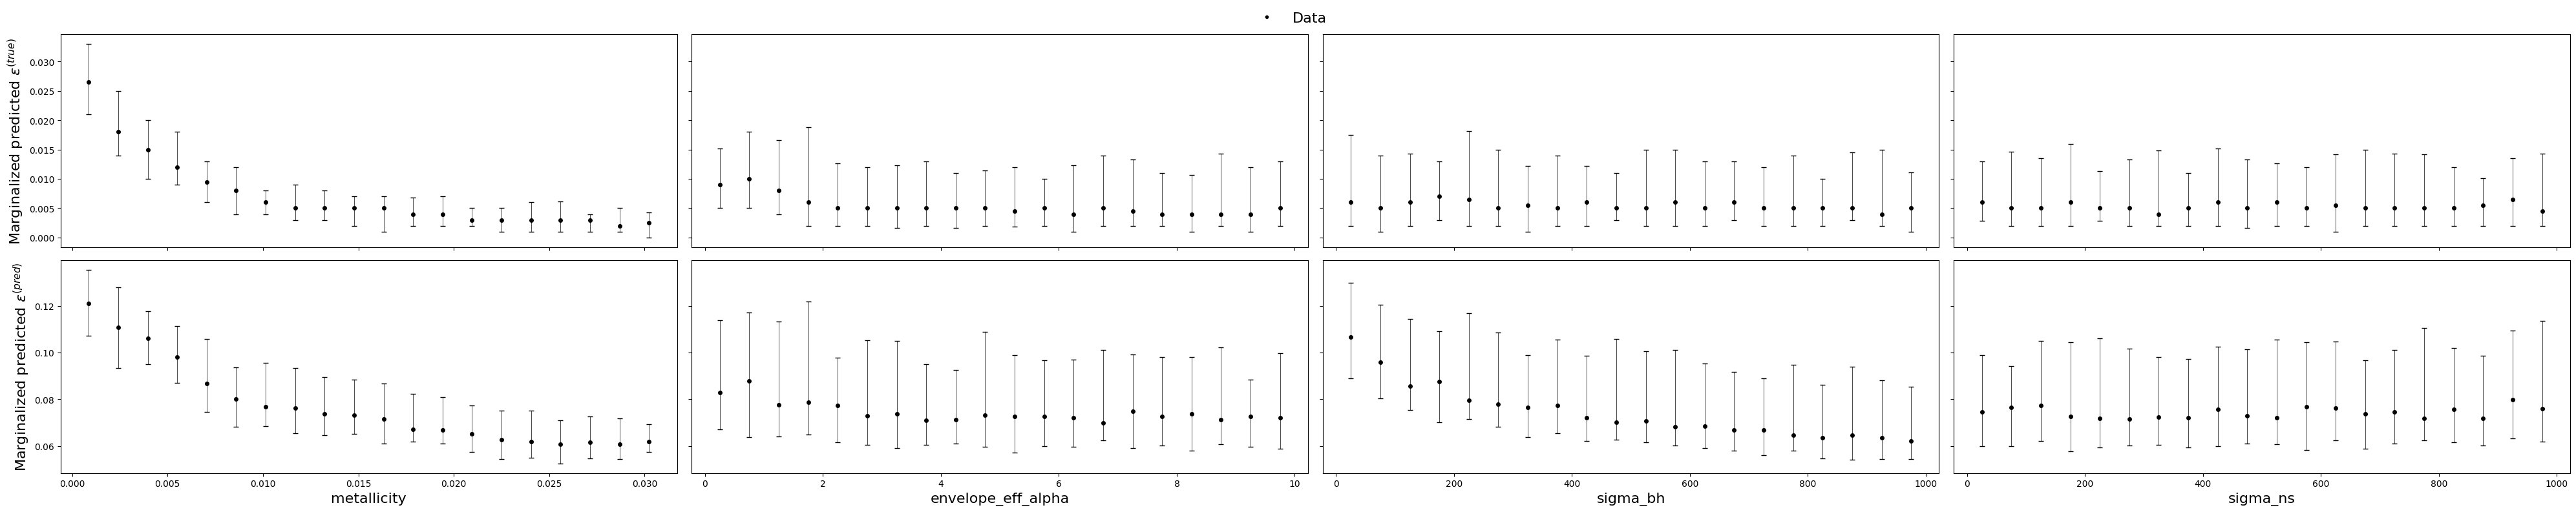

In [14]:
from resolve.helpers import ModelVisualizer

# Set parameter boundaries
xmin    = config_file["simulation_settings"]["theta_min"]
xmax    = config_file["simulation_settings"]["theta_max"]

parameters={}
for i,x in enumerate(dataset_predict.parameters["theta"]["selected_labels"]):
    parameters[x]=[xmin[i],xmax[i]]
vis = ModelVisualizer(fidelities=["true","pred"], parameters = parameters)
tmp = theta[:,0]
fig = vis.plot_projection([theta, theta], [y_true, y_pred])
fig.savefig(f"{path_out}/model_{version}_feature_projection.png")

#  Start TensorBoard

Run this in terminal:

tensorboard --logdir=\<path to tensor board log dir\> --host=0.0.0.0 --port=7007

Open:

http://localhost:7007/